Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

# Model Zoo -- Multilayer bidirectional RNN with LSTM

Demo of a bidirectional RNN for sentiment classification (here: a binary classification problem with two labels, positive and negative) using LSTM (Long Short Term Memory) cells.

In [1]:
!pip install -q IPython
!pip install -q ipykernel
!pip install -q watermark
!pip install -q matplotlib
!pip install -q sklearn
!pip install -q pandas
!pip install -q pydot
!pip install -q hiddenlayer
!pip install -q graphviz

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

import torch
import torch.nn.functional as F
from torchtext import data
from torchtext import datasets
import time
import random

torch.backends.cudnn.deterministic = True

Sebastian Raschka 

CPython 3.6.9
IPython 5.5.0

torch 1.5.1+cu101


## General Settings

In [3]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BIDIRECTIONAL = True

EMBEDDING_DIM = 128
NUM_LAYERS = 2
HIDDEN_DIM = 128
OUTPUT_DIM = 1

## Dataset

Load the IMDB Movie Review dataset:

In [4]:
TEXT = data.Field(tokenize='spacy',
                  include_lengths=True) # necessary for packed_padded_sequence
LABEL = data.LabelField(dtype=torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(RANDOM_SEED),
                                          split_ratio=0.8)

print(f'Num Train: {len(train_data)}')
print(f'Num Valid: {len(valid_data)}')
print(f'Num Test: {len(test_data)}')

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 10.3MB/s]


Num Train: 20000
Num Valid: 5000
Num Test: 25000


Build the vocabulary based on the top "VOCABULARY_SIZE" words:

In [5]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 20002
Number of classes: 2


The TEXT.vocab dictionary will contain the word counts and indices. The reason why the number of words is VOCABULARY_SIZE + 2 is that it contains to special tokens for padding and unknown words: `<unk>` and `<pad>`.

Make dataset iterators:

In [6]:
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_within_batch=True, # necessary for packed_padded_sequence
    device=DEVICE)

Testing the iterators (note that the number of rows depends on the longest document in the respective batch):

In [7]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.text[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break
    
print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.text[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break
    
print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.text[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break

Train
Text matrix size: torch.Size([133, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([61, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([42, 128])
Target vector size: torch.Size([128])


## Model

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=NUM_LAYERS,
                           bidirectional=BIDIRECTIONAL)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, text, text_length):

        #[sentence len, batch size] => [sentence len, batch size, embedding size]
        embedded = self.embedding(text)
        
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_length)
        
        packed_output, (hidden, cell) = self.rnn(packed)
        
        # combine both directions
        combined = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        return self.fc(combined.squeeze(0)).view(-1)

In [9]:
INPUT_DIM = len(TEXT.vocab)

torch.manual_seed(RANDOM_SEED)
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_opset9.py:1586: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


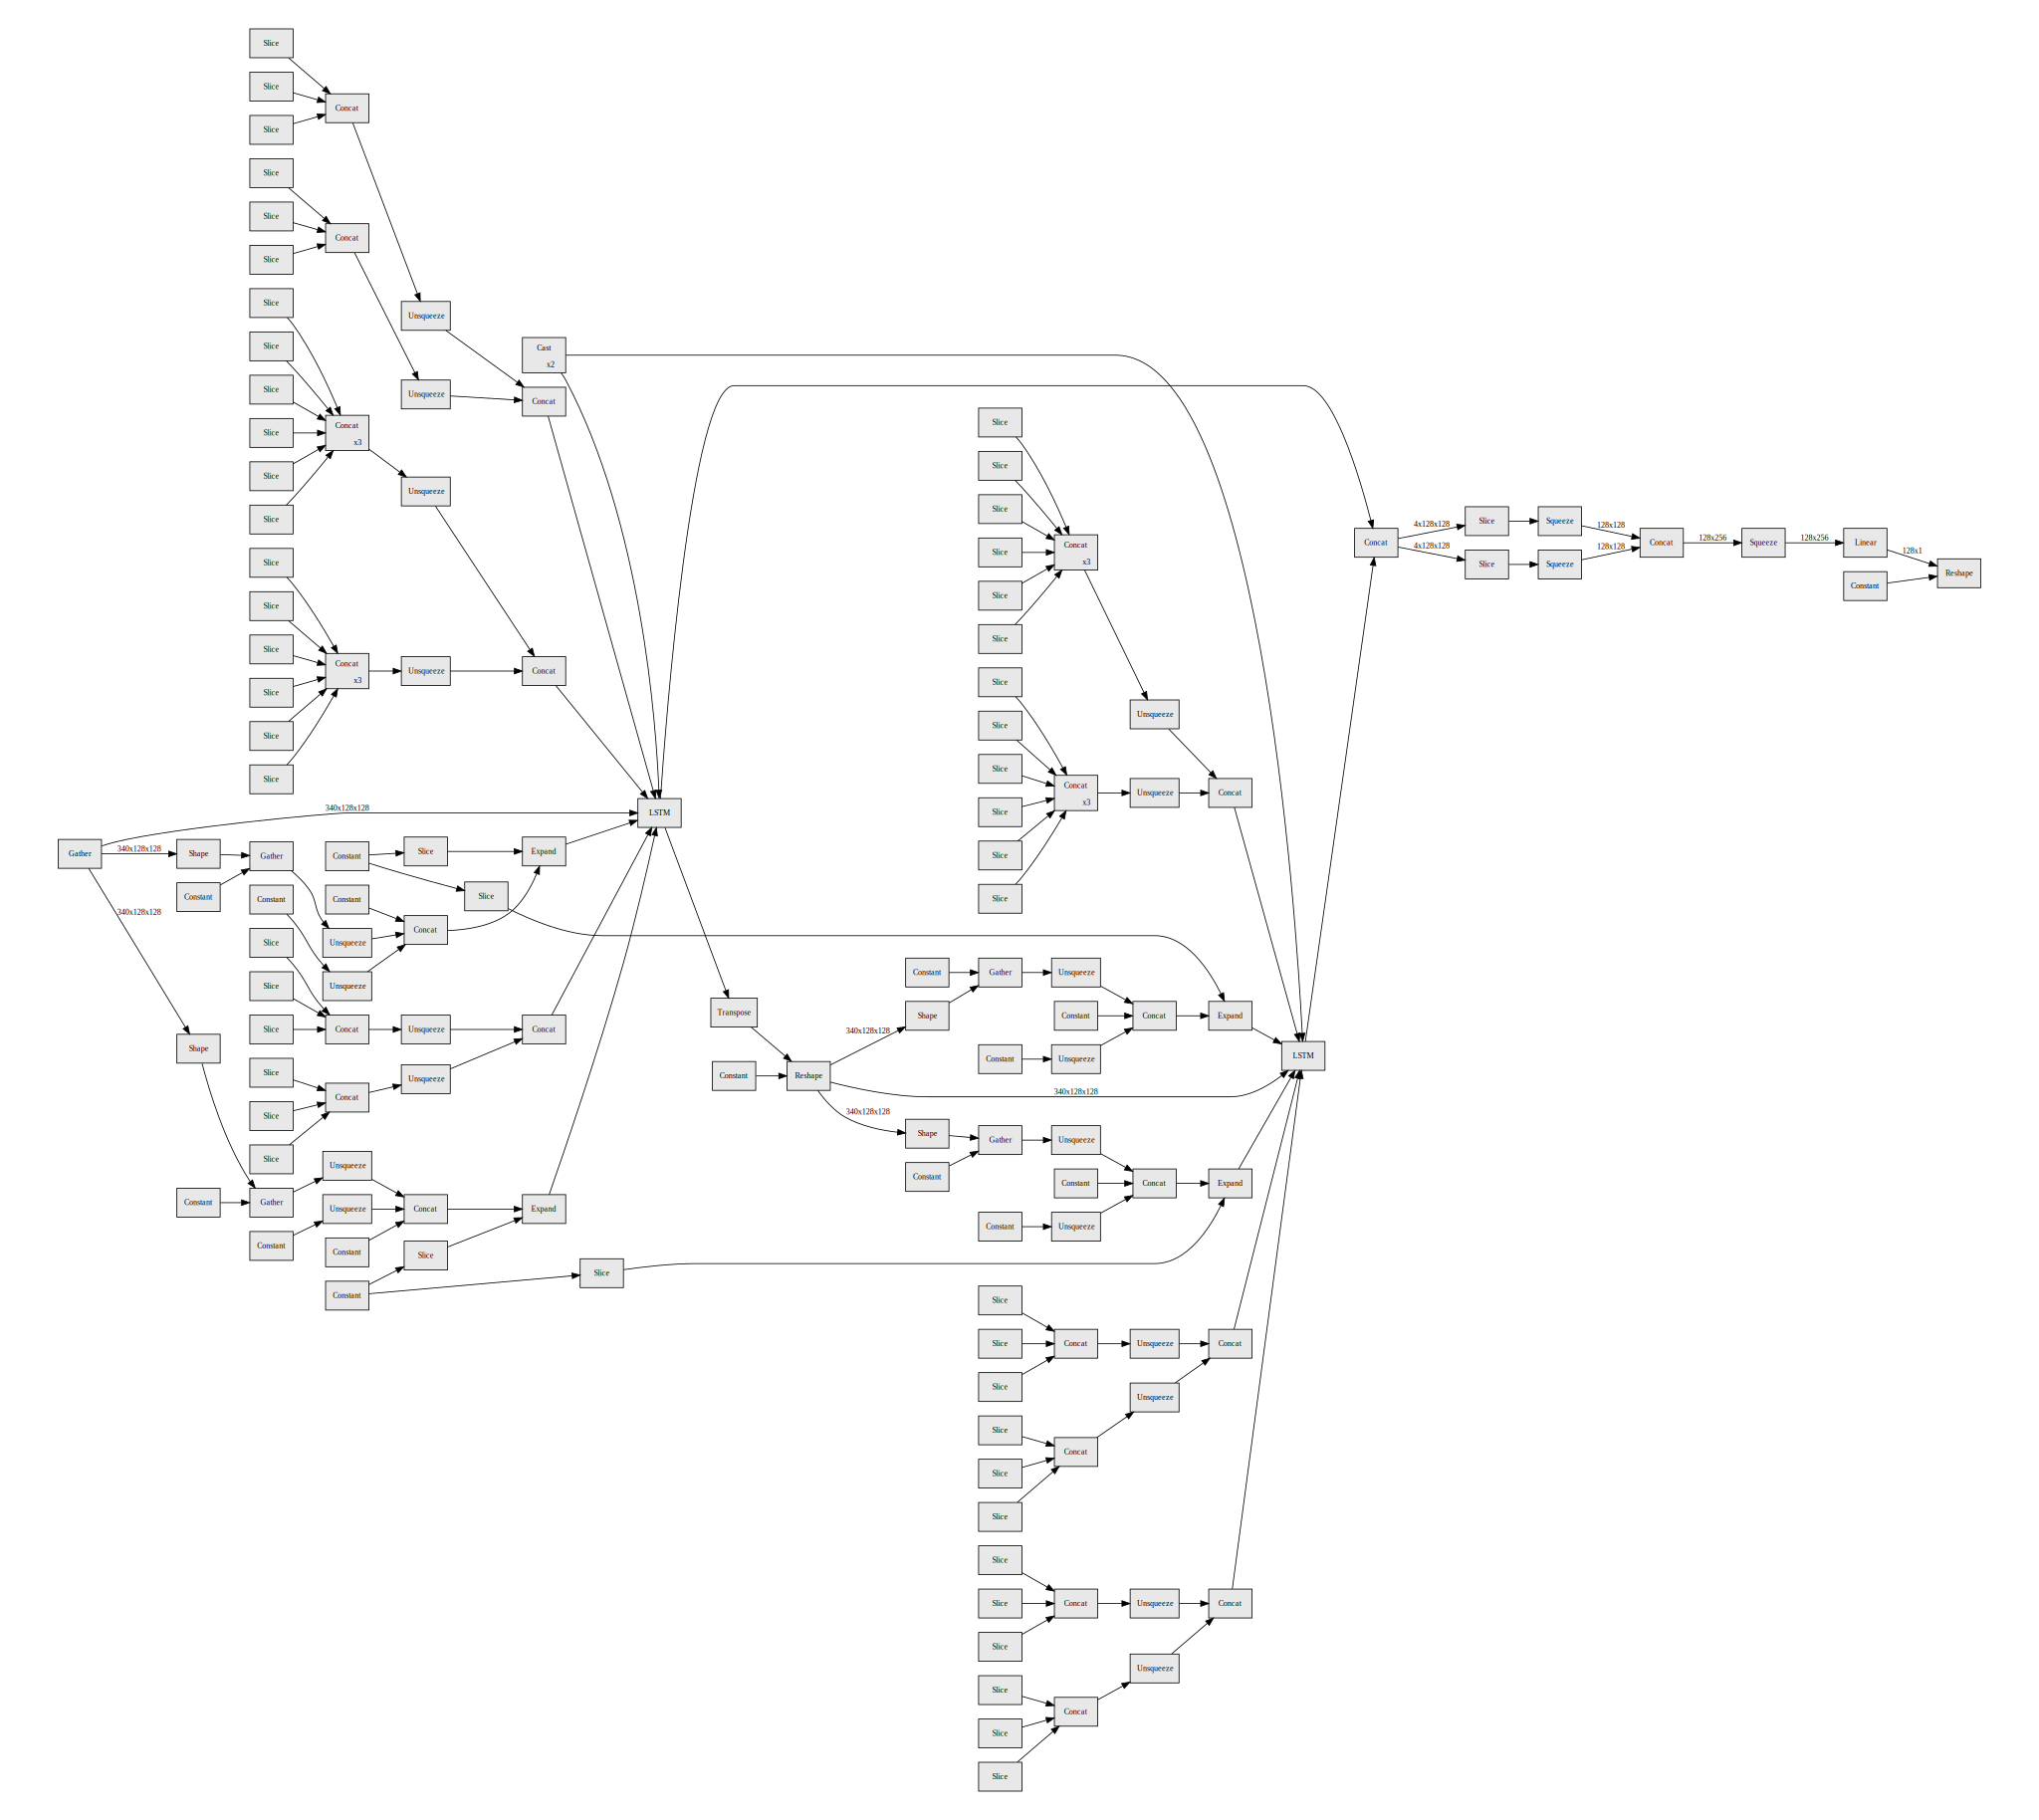

In [12]:
import hiddenlayer as hl
batch = next(iter(train_loader))
hl.build_graph(model, batch.text)

## Training

In [13]:
def compute_binary_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(data_loader):
            text, text_lengths = batch_data.text
            logits = model(text, text_lengths)
            predicted_labels = (torch.sigmoid(logits) > 0.5).long()
            num_examples += batch_data.label.size(0)
            correct_pred += (predicted_labels == batch_data.label.long()).sum()
        return correct_pred.float()/num_examples * 100

In [14]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text, text_lengths = batch_data.text
        
        ### FORWARD AND BACK PROP
        logits = model(text, text_lengths)
        cost = F.binary_cross_entropy_with_logits(logits, batch_data.label)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Cost: {cost:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_binary_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_binary_accuracy(model, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_binary_accuracy(model, test_loader, DEVICE):.2f}%')

Epoch: 001/015 | Batch 000/157 | Cost: 0.6930
Epoch: 001/015 | Batch 050/157 | Cost: 0.6893
Epoch: 001/015 | Batch 100/157 | Cost: 0.6860
Epoch: 001/015 | Batch 150/157 | Cost: 0.6839
training accuracy: 60.40%
valid accuracy: 59.00%
Time elapsed: 0.34 min
Epoch: 002/015 | Batch 000/157 | Cost: 0.6797
Epoch: 002/015 | Batch 050/157 | Cost: 0.6449
Epoch: 002/015 | Batch 100/157 | Cost: 0.6276
Epoch: 002/015 | Batch 150/157 | Cost: 0.6202
training accuracy: 71.59%
valid accuracy: 70.32%
Time elapsed: 0.68 min
Epoch: 003/015 | Batch 000/157 | Cost: 0.5613
Epoch: 003/015 | Batch 050/157 | Cost: 0.5937
Epoch: 003/015 | Batch 100/157 | Cost: 0.5051
Epoch: 003/015 | Batch 150/157 | Cost: 0.5579
training accuracy: 77.43%
valid accuracy: 75.78%
Time elapsed: 1.02 min
Epoch: 004/015 | Batch 000/157 | Cost: 0.5188
Epoch: 004/015 | Batch 050/157 | Cost: 0.4607
Epoch: 004/015 | Batch 100/157 | Cost: 0.4620
Epoch: 004/015 | Batch 150/157 | Cost: 0.5527
training accuracy: 80.94%
valid accuracy: 79.00%

In [15]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    # based on:
    # https://github.com/bentrevett/pytorch-sentiment-analysis/blob/
    # master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [16]:
print('Probability positive:')
predict_sentiment(model, "I really love this movie. This movie is so great!")

Probability positive:


0.9825106263160706